Using device: cuda


>>> Handling LSTM Model <<<

[INFO] Found existing extended_prediction_best_model_LSTM.pt. Loading without re-training...
LSTM -> Test Loss (Huber): 46.553429
LSTM -> Test MAPE:        3.17%
LSTM -> Test Accuracy:    96.83%
LSTM -> Test MSE:         2554.752257


>>> Handling GRU Model <<<

[INFO] Found existing extended_prediction_best_model_GRU.pt. Loading without re-training...
GRU -> Test Loss (Huber): 32.922932
GRU -> Test MAPE:        2.24%
GRU -> Test Accuracy:    97.76%
GRU -> Test MSE:         1463.354985


>>> Handling RNN Model <<<

[INFO] Found existing extended_prediction_best_model_RNN.pt. Loading without re-training...
RNN -> Test Loss (Huber): 15.907505
RNN -> Test MAPE:        1.10%
RNN -> Test Accuracy:    98.90%
RNN -> Test MSE:         390.384645


>>> Handling CNN Model <<<

[INFO] Found existing extended_prediction_best_model_CNN.pt. Loading without re-training...
CNN -> Test Loss (Huber): 55.302361
CNN -> Test MAPE:        3.76%
CNN -> Test A

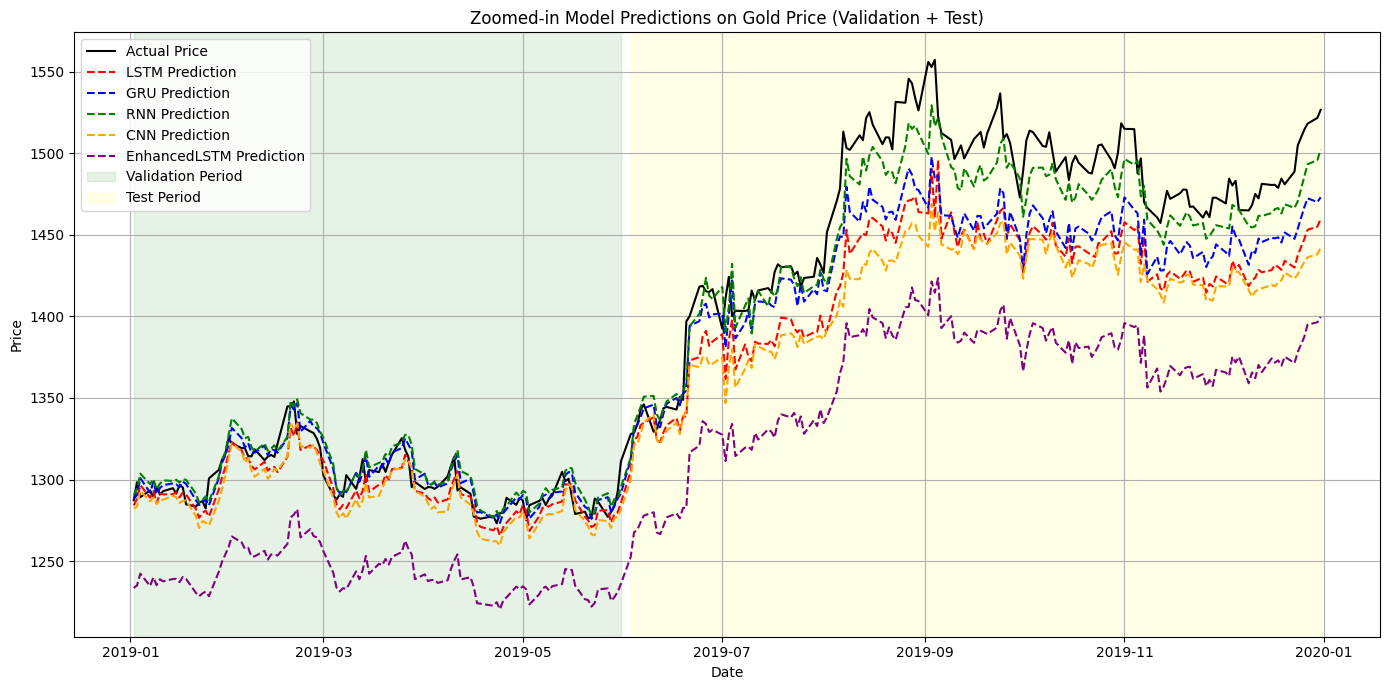

Lowest Validation MSE -> ('EnhancedLSTM', 29, 156.86405524541357)
Highest Validation R²   -> ('Actual', 29, 0.968499515862917)


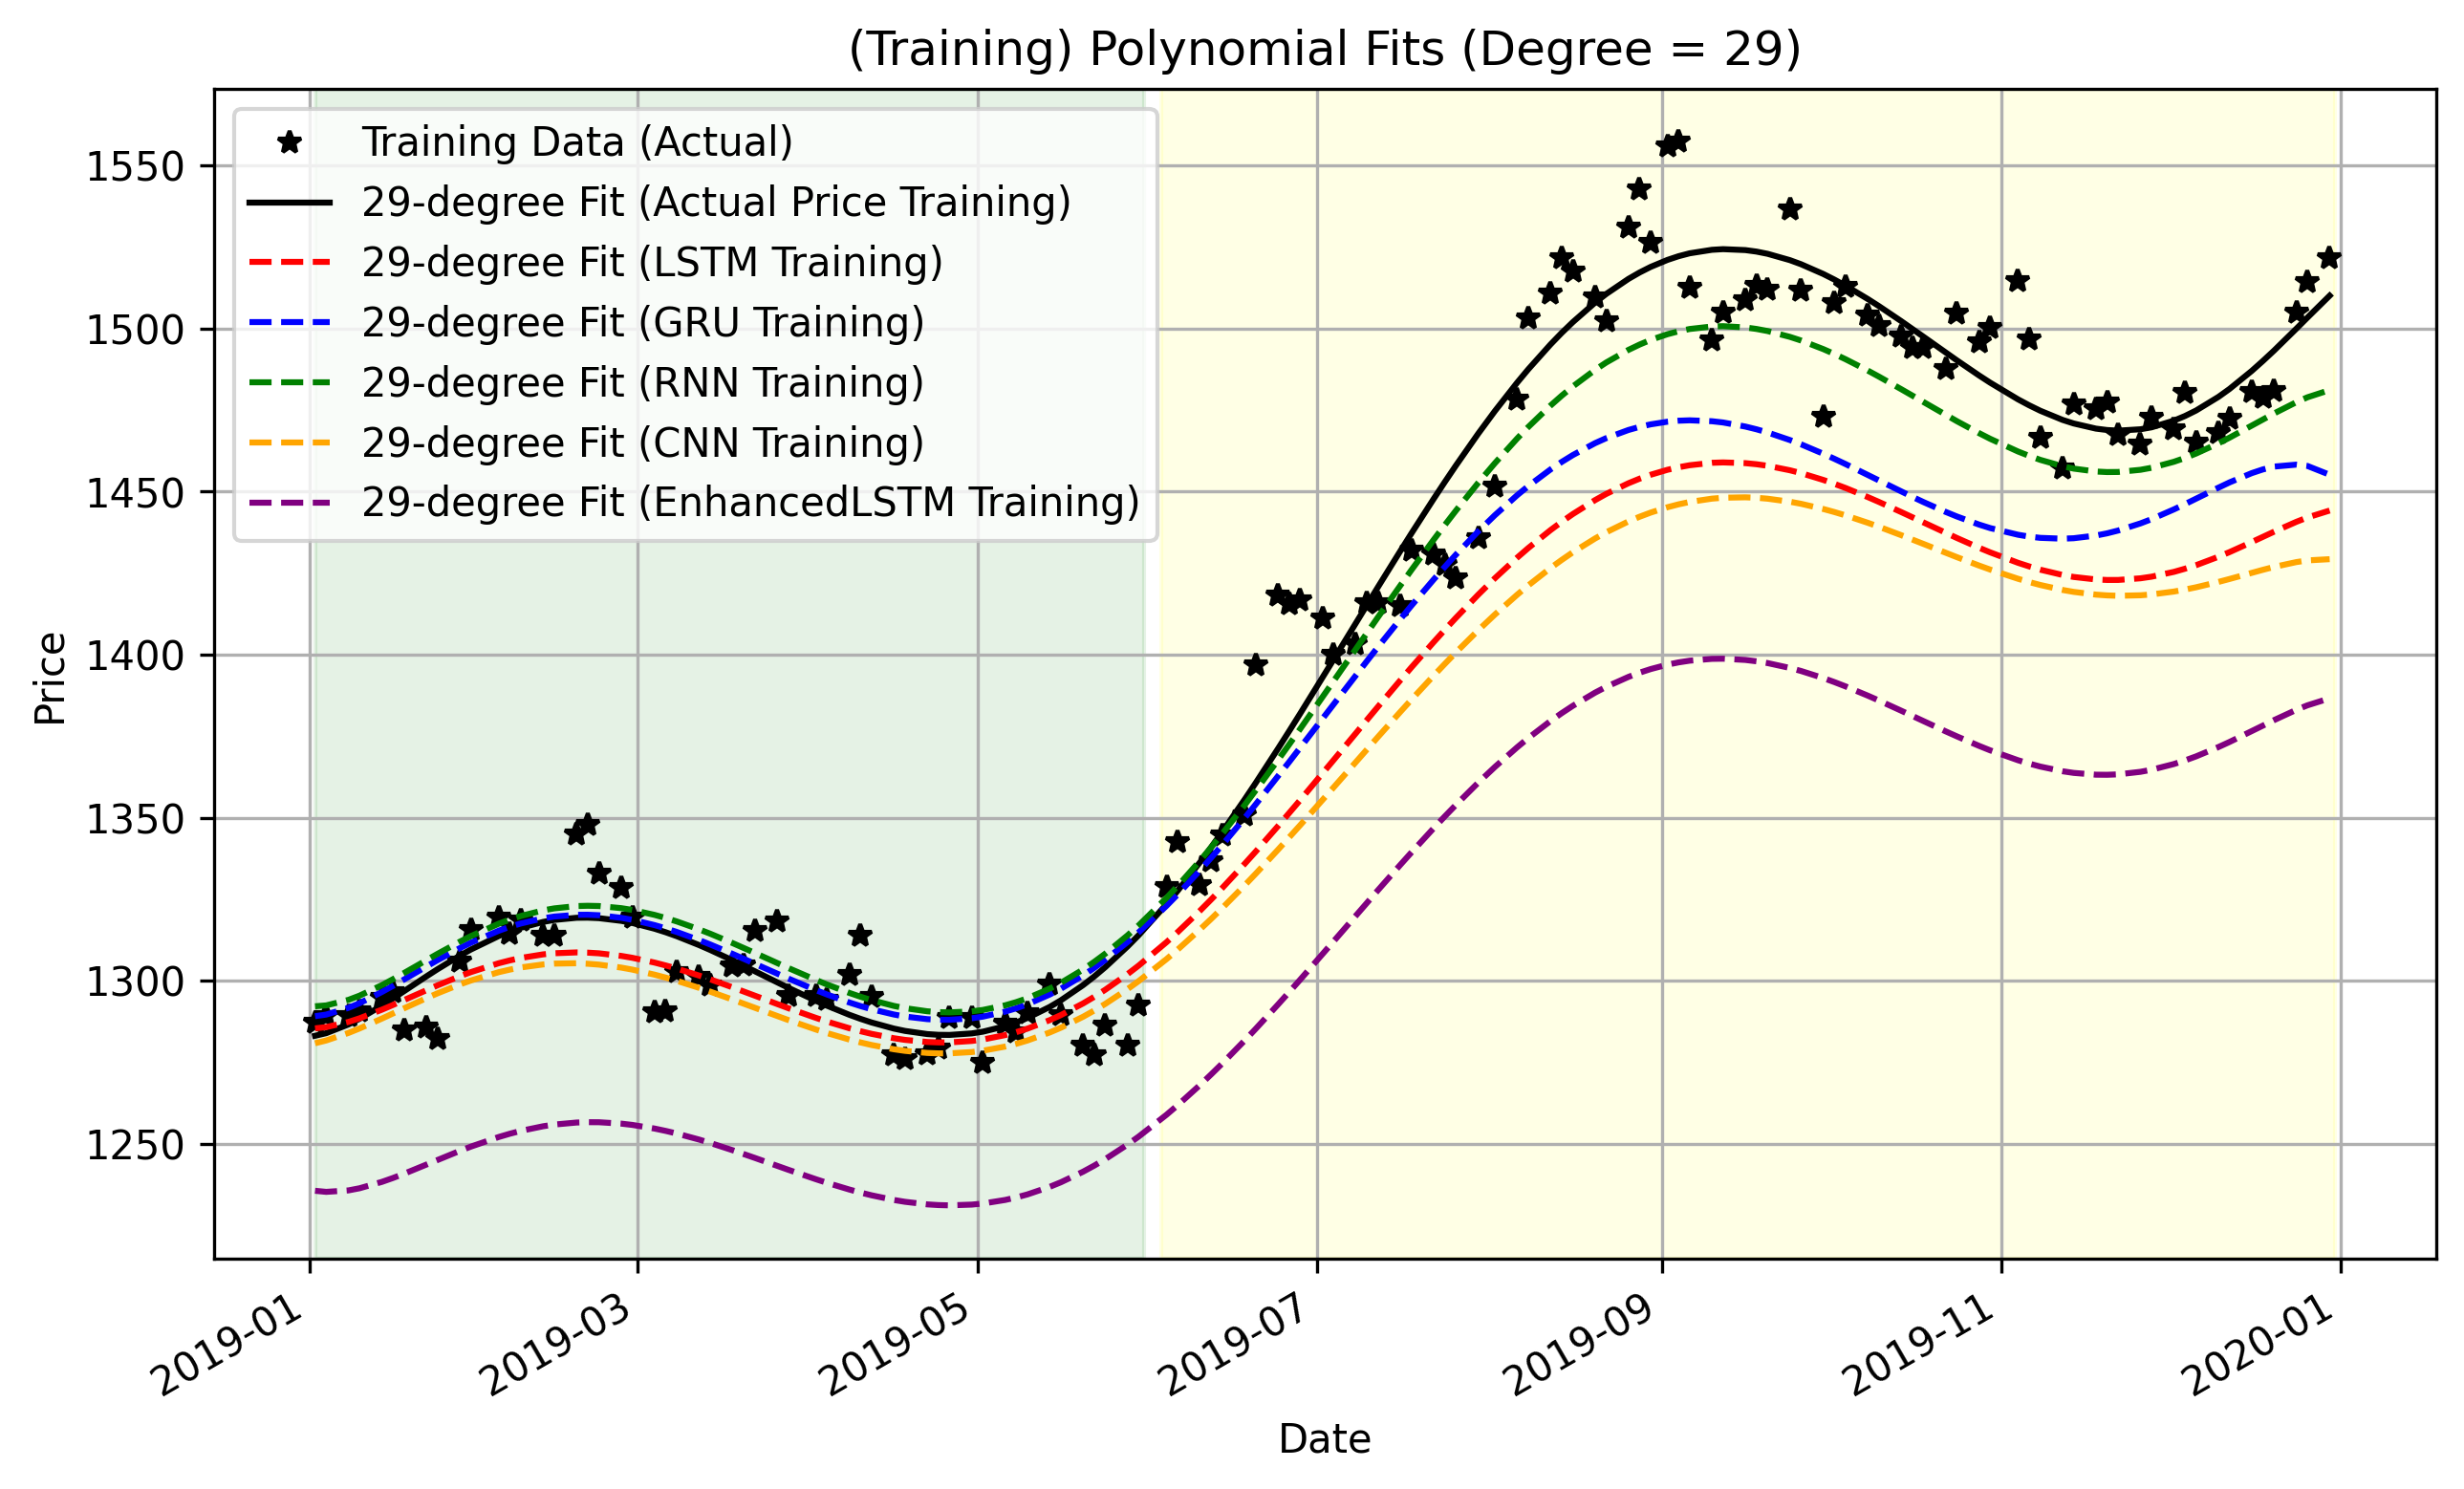

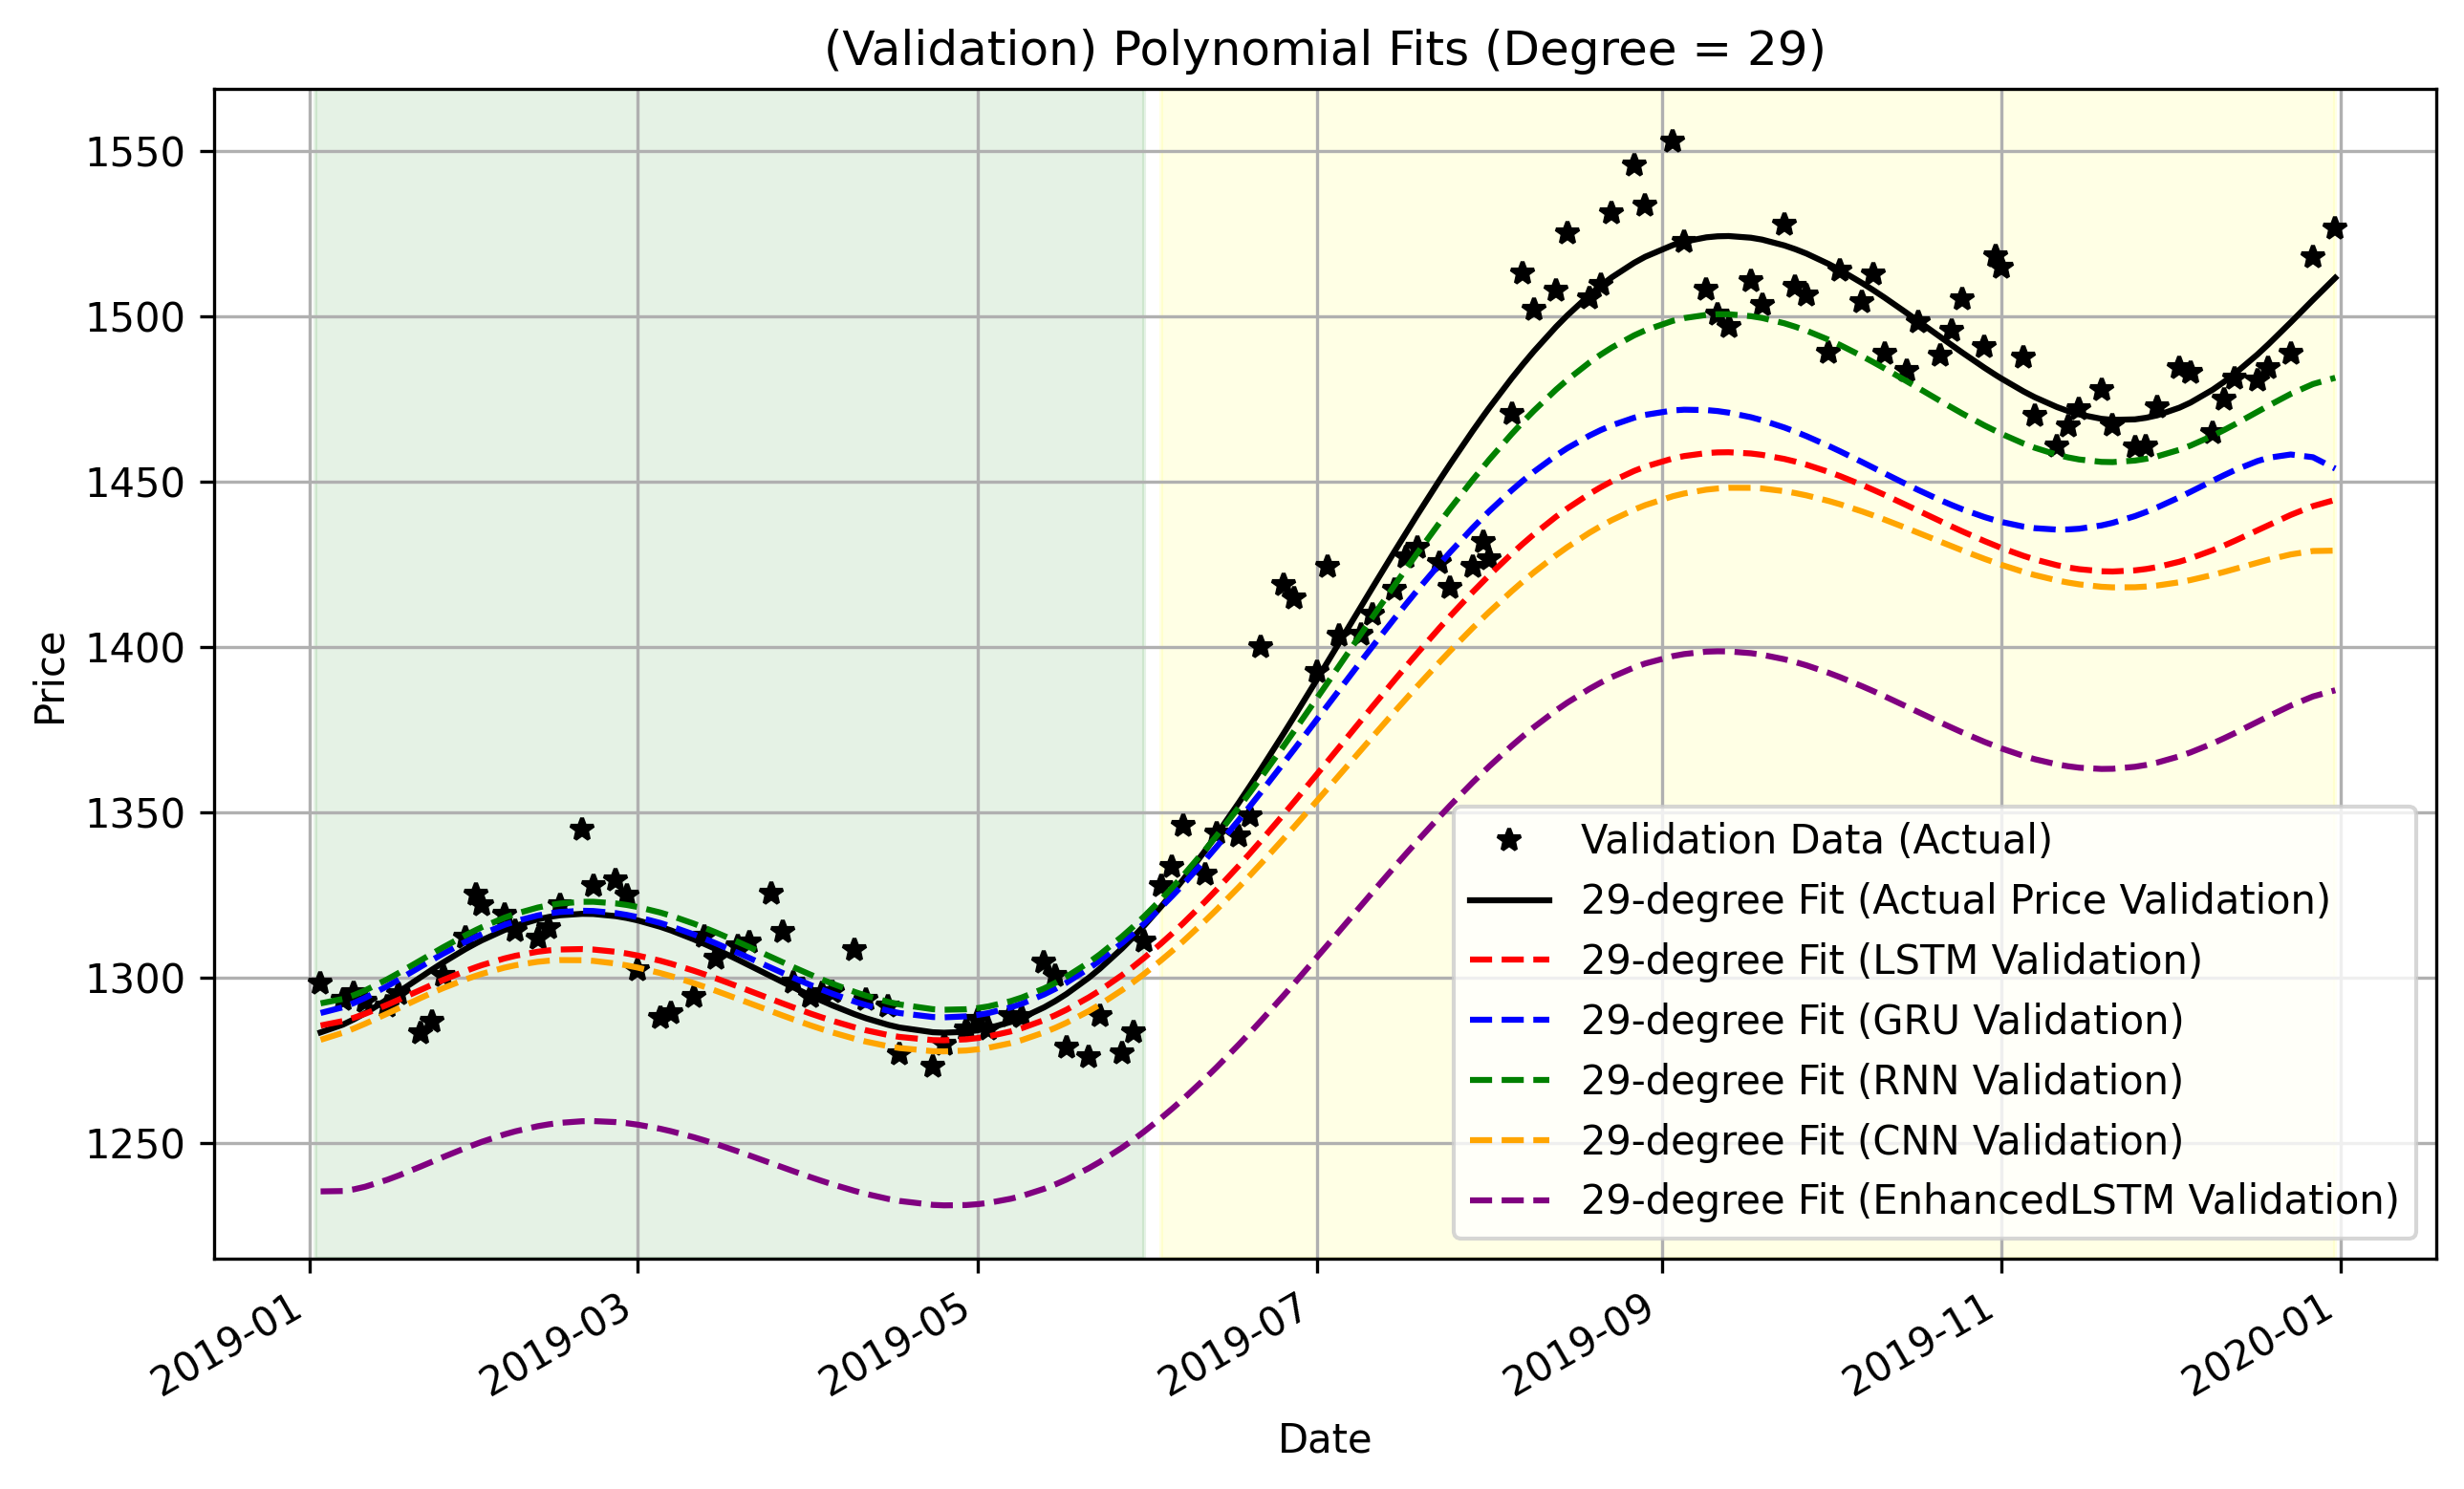

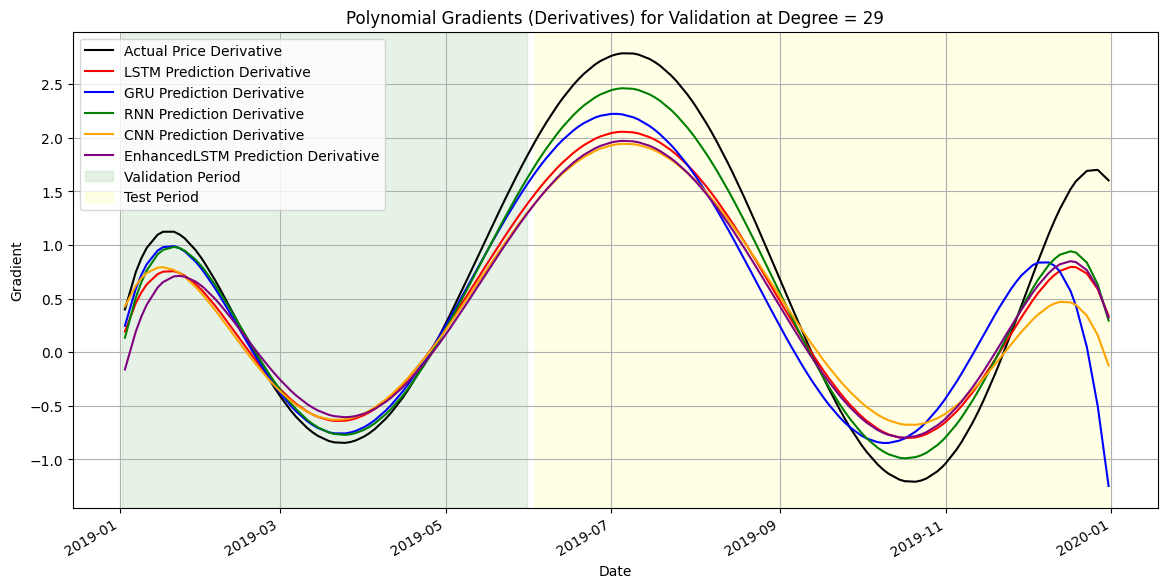


Derivative Polynomial Expressions (Degree = 28) at n = 29:
------------------------------------------------------------
Actual Price Derivative: -1.236860e-109*x^28+1.992900e-105*x^27+3.782199e-101*x^26+2.395697e-97*x^25-3.738246e-93*x^24-1.505059e-88*x^23-2.892210e-84*x^22-3.696636e-80*x^21-2.264644e-76*x^20+3.827155e-72*x^19+1.733744e-67*x^18+3.946886e-63*x^17+6.588151e-59*x^16+8.137271e-55*x^15+5.182911e-51*x^14-7.875606e-47*x^13-3.818906e-42*x^12-8.986545e-38*x^11-1.542369e-33*x^10-1.942267e-29*x^9-1.274158e-25*x^8+1.780536e-21*x^7+8.456361e-17*x^6+1.802253e-12*x^5+2.493745e-08*x^4+1.607337e-04*x^3-2.248647e+00*x^2-7.692015e+04*x^1-6.498996e+08
LSTM Derivative: -9.644990e-110*x^28+1.553201e-105*x^27+2.948892e-101*x^26+1.869977e-97*x^25-2.909190e-93*x^24-1.172624e-88*x^23-2.254297e-84*x^22-2.882774e-80*x^21-1.769668e-76*x^20+2.973692e-72*x^19+1.349845e-67*x^18+3.074553e-63*x^17+5.134063e-59*x^16+6.344909e-55*x^15+4.050333e-51*x^14-6.112901e-47*x^13-2.971815e-42*x^12-6.997358e-38*x^

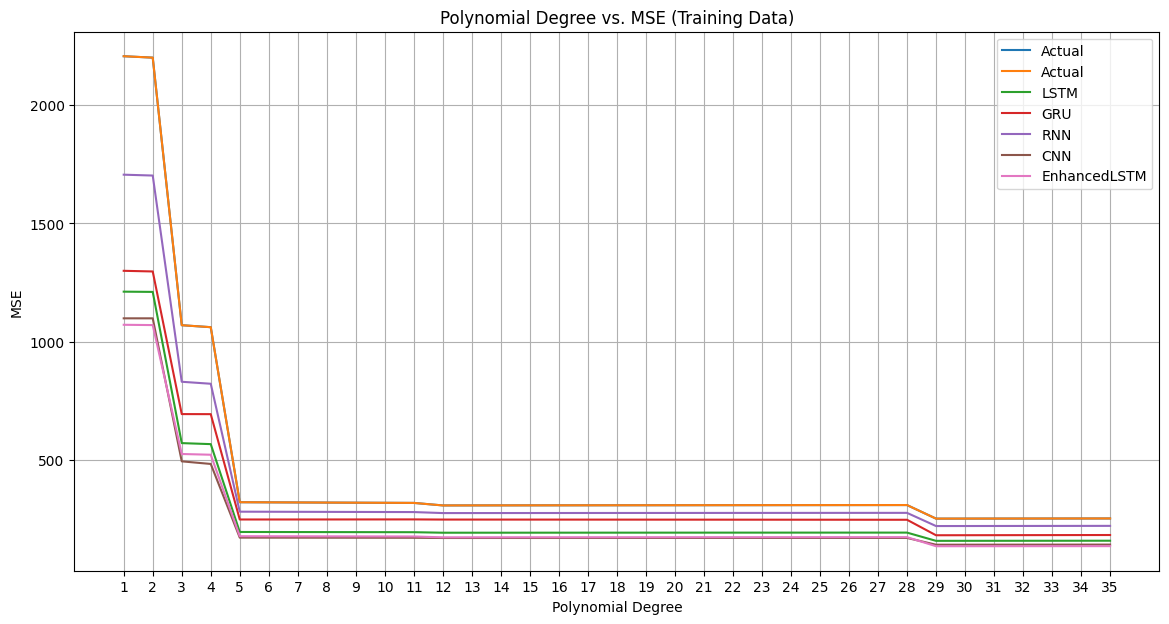

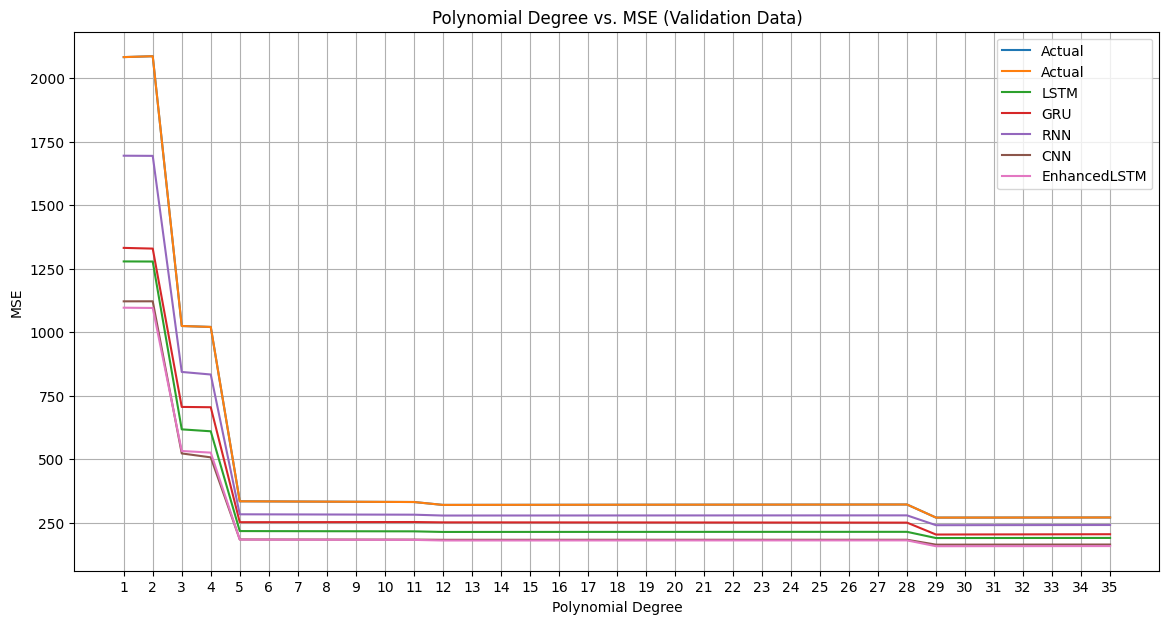

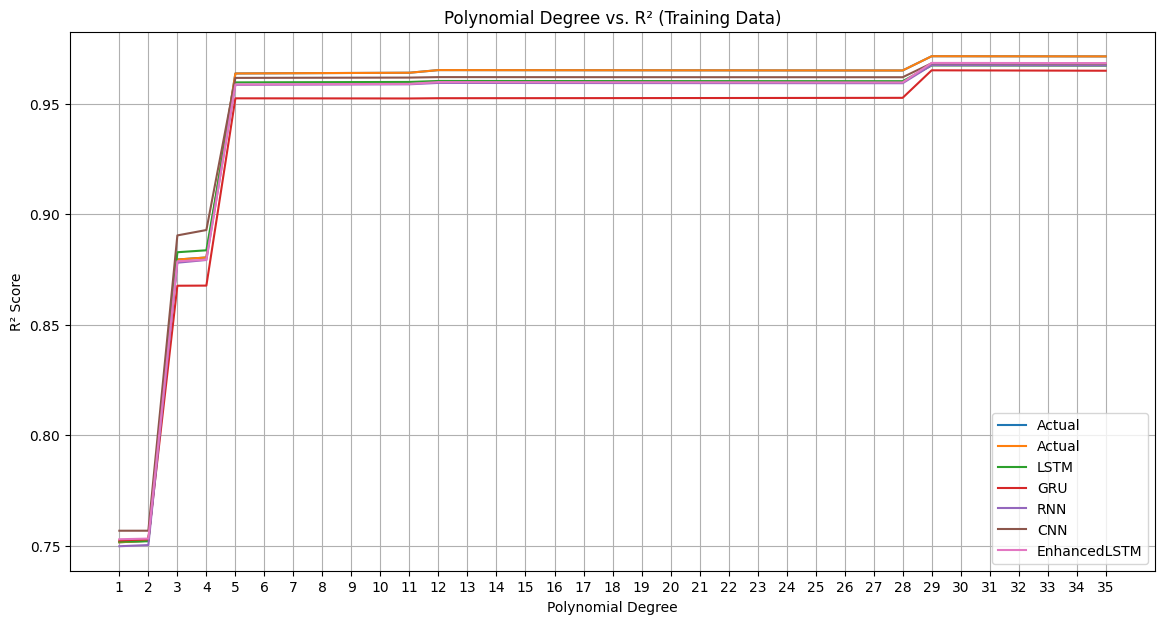

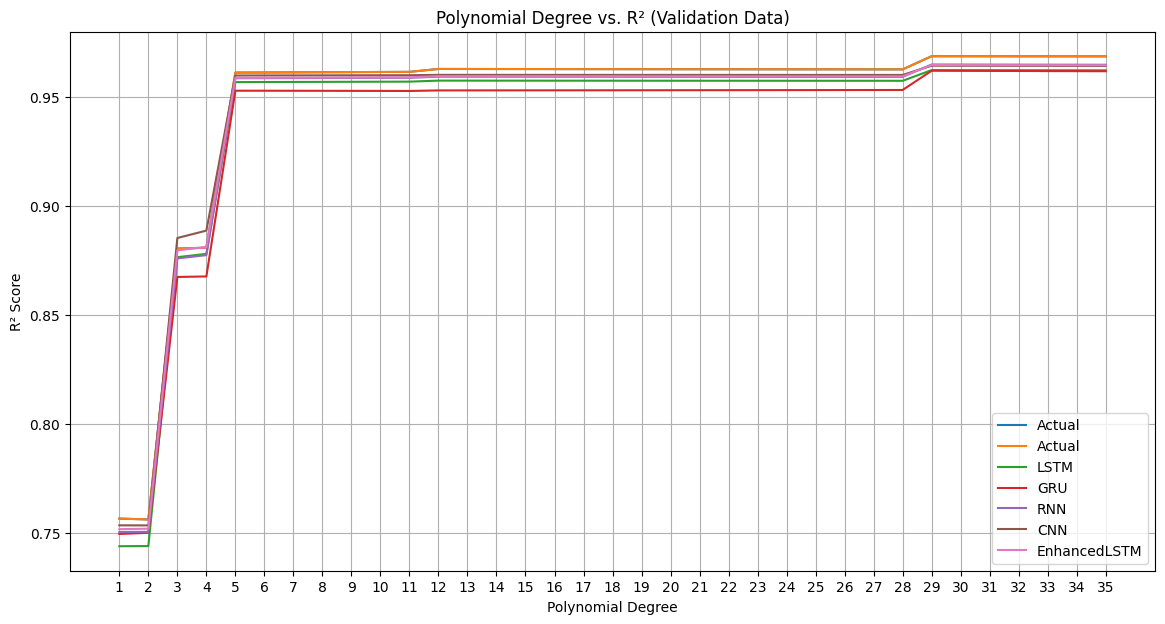

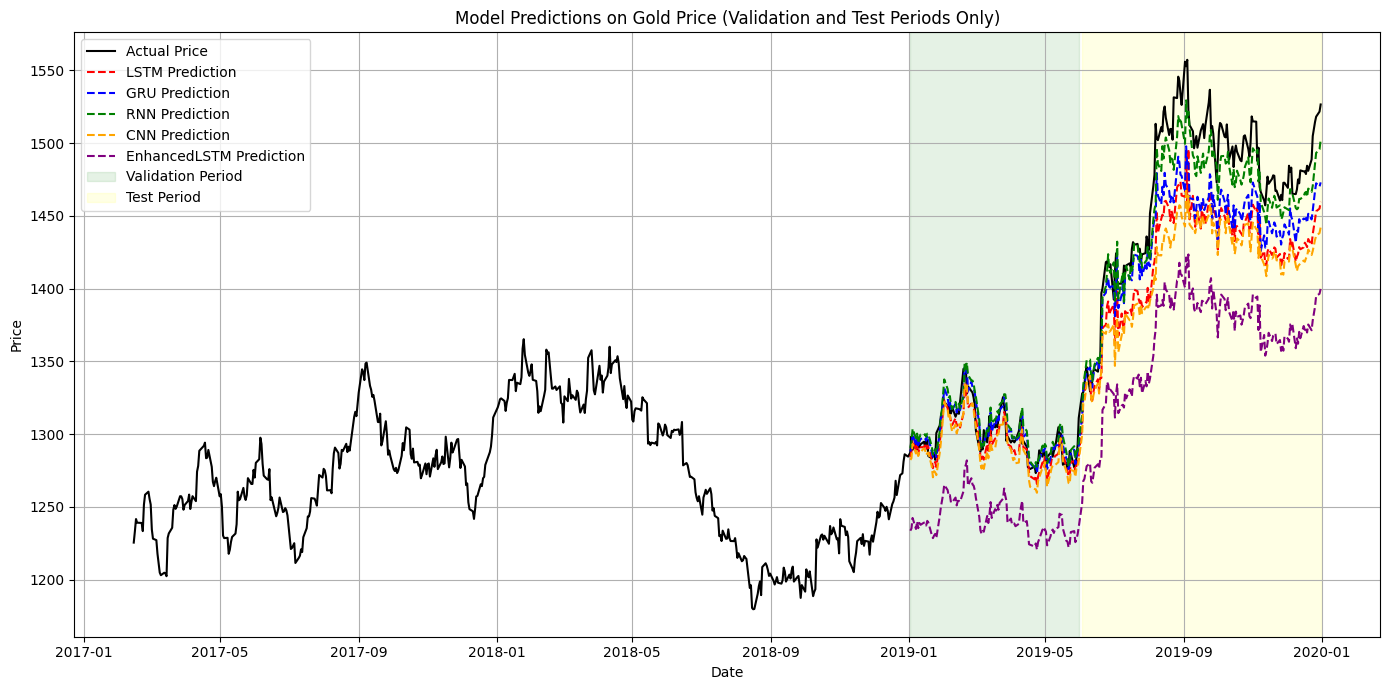

In [5]:
##############################################################################
# 1) Imports and Setup
##############################################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    mean_absolute_percentage_error, 
    mean_squared_error, 
    r2_score
)
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import os
import random
import warnings
import matplotlib.dates as mdates

warnings.filterwarnings("ignore")  # Hide any warnings for cleaner output

# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

##############################################################################
# 2) Load and Prepare Data
##############################################################################
df = pd.read_csv('Gold Price_Year 2017-2019.csv')
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

num_cols = df.columns.drop(['Date'])
df[num_cols] = df[num_cols].replace({',': ''}, regex=True)
df[num_cols] = df[num_cols].astype('float64')

assert df.duplicated().sum() == 0, "Duplicate rows found!"
assert df.isnull().sum().sum() == 0, "Missing values found!"

features = ['Price', 'Open', 'High', 'Low']
data = df[features].values

# Scale data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Create sequences
window_width = 30
X, y, dates = [], [], []
for i in range(window_width, len(data_scaled)):
    X.append(data_scaled[i - window_width : i])
    y.append(data_scaled[i, 0])  # Price as target
    dates.append(df['Date'].iloc[i])

X = np.array(X)
y = np.array(y)
dates = np.array(dates)

# Train/Val/Test masks
train_mask = (
    (dates >= pd.to_datetime('2017-01-03')) &
    (dates <= pd.to_datetime('2018-12-31'))
)
val_mask = (
    (dates >= pd.to_datetime('2019-01-02')) &
    (dates <= pd.to_datetime('2019-05-31'))
)
test_mask = (
    (dates >= pd.to_datetime('2019-06-03')) &
    (dates <= pd.to_datetime('2019-12-31'))
)

X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]
X_test, y_test = X[test_mask], y[test_mask]

train_dates = dates[train_mask]
val_dates = dates[val_mask]
test_dates = dates[test_mask]

# Convert to tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1)
X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).float().unsqueeze(1)
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float().unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##############################################################################
# 3) Define Model
##############################################################################
class BaseModel(nn.Module):
    def __init__(self, model_type='LSTM', hidden_size=128, num_layers=2, dropout=0.1, lr=0.0005):
        super(BaseModel, self).__init__()
        self.model_type = model_type
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.lr = lr
        
        if model_type == 'LSTM':
            self.rnn = nn.LSTM(
                input_size=len(features),
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True,
                dropout=dropout,
            )
            self.fc = nn.Linear(hidden_size, 1)
        elif model_type == 'GRU':
            self.rnn = nn.GRU(
                input_size=len(features),
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True,
                dropout=dropout,
            )
            self.fc = nn.Linear(hidden_size, 1)
        elif model_type == 'RNN':
            self.rnn = nn.RNN(
                input_size=len(features),
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True,
                nonlinearity='relu',
                dropout=dropout,
            )
            self.fc = nn.Linear(hidden_size, 1)
        elif model_type == 'CNN':
            self.conv1 = nn.Conv1d(in_channels=len(features), out_channels=64, kernel_size=3)
            self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
            conv_output_length = window_width - 2 * (3 - 1)
            self.fc = nn.Linear(128 * conv_output_length, 1)
        elif model_type == 'EnhancedLSTM':
            self.rnn = nn.LSTM(
                input_size=len(features),
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True,
                dropout=dropout
            )
            self.bn = nn.BatchNorm1d(hidden_size)
            self.dropout_layer = nn.Dropout(dropout)
            self.fc = nn.Linear(hidden_size, 1)
        else:
            raise ValueError("Invalid model_type.")

    def forward(self, x):
        if self.model_type == 'CNN':
            x = x.permute(0, 2, 1)  # (batch, channels, seq_len)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            out = self.fc(x)
        elif self.model_type == 'EnhancedLSTM':
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.bn(out)
            out = self.dropout_layer(out)
            out = self.fc(out)
        else:
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.fc(out)
        return out

##############################################################################
# 4) Utilities
##############################################################################
class EarlyStopping:
    def __init__(self, patience=150, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered")
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

def inverse_transform(y_scaled):
    """Inverse transform the 'Price' from scaled to original domain."""
    y_scaled = np.array(y_scaled).reshape(-1, 1)
    zeros = np.zeros((y_scaled.shape[0], len(features) - 1))
    y_combined = np.hstack((y_scaled, zeros))
    y_inv = scaler.inverse_transform(y_combined)
    return y_inv[:, 0]

def evaluate_on_validation(model, val_loader, criterion):
    model.eval()
    val_losses = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_losses.append(loss.item())
    return np.mean(val_losses)

def train_model(model, train_loader, val_loader, num_epochs=1000, patience=150):
    criterion = nn.HuberLoss()
    optimizer = optim.AdamW(model.parameters(), lr=model.lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=patience)
    early_stopping = EarlyStopping(patience=patience, min_delta=0)

    best_val_loss = float('inf')
    train_losses, val_losses = [], []
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        batch_losses = []
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        
        avg_train_loss = np.mean(batch_losses)
        train_losses.append(avg_train_loss)

        # Validation
        avg_val_loss = evaluate_on_validation(model, val_loader, criterion)
        val_losses.append(avg_val_loss)
        
        scheduler.step(avg_val_loss)
        early_stopping(avg_val_loss)
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()
        
        if early_stopping.early_stop:
            break

    # Restore best weights
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return best_val_loss, train_losses, val_losses

##############################################################################
# 5) Hyper-Parameter Search
##############################################################################
def hyperparameter_search(model_type, train_loader, val_loader):
    hidden_sizes = [64, 128]
    dropouts = [0.1, 0.2]
    lrs = [0.0005, 0.001]
    num_layers_list = [2, 3]

    best_combination = None
    best_val_loss = float('inf')
    best_train_losses = []
    best_val_losses = []

    for hidden_size in hidden_sizes:
        for dropout in dropouts:
            for lr in lrs:
                for num_layers in num_layers_list:
                    model = BaseModel(
                        model_type=model_type,
                        hidden_size=hidden_size,
                        dropout=dropout,
                        lr=lr,
                        num_layers=num_layers
                    ).to(device)

                    print(f"\n[HP-Search] {model_type} | hidden={hidden_size}, drop={dropout}, lr={lr}, layers={num_layers}")
                    val_loss, train_hist, val_hist = train_model(
                        model, train_loader, val_loader, num_epochs=300, patience=50
                    )
                    
                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        best_combination = {
                            'hidden_size': hidden_size,
                            'dropout': dropout,
                            'lr': lr,
                            'num_layers': num_layers,
                        }
                        best_train_losses = train_hist
                        best_val_losses = val_hist

    print(f"\n[HP-Search] Best combination for {model_type}: {best_combination} with val_loss={best_val_loss:.6f}")
    return best_combination, best_train_losses, best_val_losses

##############################################################################
# 6) Load or Train (Skipping Re-Training If File Exists)
##############################################################################
def get_model_outputs(model_type, force_train=False):
    """
    1) Checks 'extended_prediction_best_model_<model_type>.pt'.
       - If file exists and force_train=False, load the file directly.
       - Otherwise, hyper-param search + train + save file.
    2) Returns dictionary with predictions, best_params, etc.
    """
    extended_pred_path = f'extended_prediction_best_model_{model_type}.pt'
    
    if (not force_train) and os.path.exists(extended_pred_path):
        print(f"\n[INFO] Found existing {extended_pred_path}. Loading without re-training...")
        loaded_data = torch.load(extended_pred_path, map_location=device)
        
        best_params = loaded_data['best_params']
        y_val_pred_inv = loaded_data['y_val_pred_inv']
        y_test_pred_inv = loaded_data['y_test_pred_inv']
        train_losses_per_epoch = loaded_data['train_losses_per_epoch']
        val_losses_per_epoch = loaded_data['val_losses_per_epoch']
        
        # Reconstruct the best model if needed
        best_model = BaseModel(
            model_type=model_type,
            hidden_size=best_params['hidden_size'],
            dropout=best_params['dropout'],
            lr=best_params['lr'],
            num_layers=best_params['num_layers']
        ).to(device)
        best_model.load_state_dict(loaded_data['state_dict'])
        best_model.eval()

    else:
        print(f"\n[INFO] No file or force_train=True. Searching hyper-params for {model_type}...")
        best_params, _, _ = hyperparameter_search(model_type, train_loader, val_loader)
        
        best_model = BaseModel(
            model_type=model_type,
            hidden_size=best_params['hidden_size'],
            dropout=best_params['dropout'],
            lr=best_params['lr'],
            num_layers=best_params['num_layers']
        ).to(device)

        print(f"\nRetraining {model_type} with best hyperparams: {best_params}")
        _, train_losses_per_epoch, val_losses_per_epoch = train_model(
            best_model, train_loader, val_loader, num_epochs=800, patience=150
        )

        # Inference on test
        criterion = nn.HuberLoss()
        best_model.eval()
        test_losses = []
        y_test_pred_list = []
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = best_model(X_batch)
                loss = criterion(y_pred, y_batch)
                test_losses.append(loss.item())
                y_test_pred_list.append(y_pred.cpu().numpy())

        y_test_pred_array = np.concatenate(y_test_pred_list, axis=0)
        # Validation predictions
        y_val_pred_list = []
        with torch.no_grad():
            for X_batch, _ in val_loader:
                X_batch = X_batch.to(device)
                y_val_pred_list.append(best_model(X_batch).cpu().numpy())
        y_val_pred = np.concatenate(y_val_pred_list, axis=0)

        y_val_pred_inv = inverse_transform(y_val_pred)
        y_test_pred_inv = inverse_transform(y_test_pred_array)

        # Save
        save_dict = {
            'state_dict': best_model.state_dict(),
            'best_params': best_params,
            'y_val_pred_inv': y_val_pred_inv,
            'y_test_pred_inv': y_test_pred_inv,
            'train_losses_per_epoch': train_losses_per_epoch,
            'val_losses_per_epoch': val_losses_per_epoch,
        }
        torch.save(save_dict, extended_pred_path)
        print(f"[INFO] Saved best {model_type} model + predictions to {extended_pred_path}")

    # Compute final test metrics in original scale
    # (We have y_test_inv from global scope, or we can handle it outside)
    # We'll just store them here if needed outside
    results = {
        'model_name': model_type,
        'best_params': best_params,
        'y_val_pred_inv': y_val_pred_inv,
        'y_test_pred_inv': y_test_pred_inv,
        'train_losses_per_epoch': train_losses_per_epoch,
        'val_losses_per_epoch': val_losses_per_epoch,
        'best_model': best_model,  # If we need the actual model
    }
    return results

##############################################################################
# 7) Main Flow: Gather Each Model's Output & Print Test Metrics
##############################################################################
model_names = ['LSTM', 'GRU', 'RNN', 'CNN', 'EnhancedLSTM']
all_results = {}

# We'll need the unscaled "y_test_inv" to compute metrics
y_test_inv = inverse_transform(y_test_tensor.numpy())

for mname in model_names:
    print(f"\n\n>>> Handling {mname} Model <<<")
    results = get_model_outputs(mname, force_train=False)
    all_results[mname] = results

    # Compute test metrics from loaded predictions
    y_test_pred_inv = results['y_test_pred_inv']
    
    # 1) Huber Loss in original scale
    huber_criterion = nn.HuberLoss()
    # Convert arrays to torch tensors for the loss
    test_loss_val = huber_criterion(
        torch.from_numpy(y_test_pred_inv).float(),
        torch.from_numpy(y_test_inv).float()
    ).item()
    
    # 2) MAPE
    test_mape = mean_absolute_percentage_error(y_test_inv, y_test_pred_inv)
    # 3) Accuracy
    test_accuracy = 100 - test_mape * 100
    # 4) Test MSE
    test_mse = mean_squared_error(y_test_inv, y_test_pred_inv)

    print(f"{mname} -> Test Loss (Huber): {test_loss_val:.6f}")
    print(f"{mname} -> Test MAPE:        {test_mape * 100:.2f}%")
    print(f"{mname} -> Test Accuracy:    {test_accuracy:.2f}%")
    print(f"{mname} -> Test MSE:         {test_mse:.6f}")

##############################################################################
# 8) Zoomed-in Plot of Predictions on Validation + Test
##############################################################################
model_colors = {
    'LSTM': 'red',
    'GRU': 'blue',
    'RNN': 'green',
    'CNN': 'orange',
    'EnhancedLSTM': 'purple',
}

# We'll also need the unscaled "y_val_inv"
y_val_inv = inverse_transform(y_val_tensor.numpy())

plt.figure(figsize=(14, 7))
zoom_dates = np.concatenate((val_dates, test_dates))
zoom_actual = np.concatenate((y_val_inv, y_test_inv))

# Plot actual
plt.plot(zoom_dates, zoom_actual, color='black', label='Actual Price')

# Plot predictions
for model_name, results in all_results.items():
    y_pred_combined = np.concatenate((results['y_val_pred_inv'], results['y_test_pred_inv']))
    model_dates = np.concatenate((val_dates, test_dates))
    plt.plot(model_dates, y_pred_combined, color=model_colors[model_name], linestyle='--',
             label=f'{model_name} Prediction')

# Highlight validation and test periods
plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1, label='Validation Period')
plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1, label='Test Period')

plt.title('Zoomed-in Model Predictions on Gold Price (Validation + Test)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##############################################################################
# 9) Polynomial Fitting & Gradient Calculations at Degree = 29
##############################################################################
# You can reuse the exact polynomial-fitting code from before.
# Here's a concise version focusing on the final "n=29" scenario
# and printing expressions for Actual + each model in order.

# Combine val+test
zoom_dates = np.concatenate((val_dates, test_dates))
zoom_actual = np.concatenate((y_val_inv, y_test_inv))
date_numeric = mdates.date2num(zoom_dates)

# Even (training_mask) vs odd (validation_mask) day partition
training_mask = np.array([d.day % 2 == 0 for d in zoom_dates]) 
validation_mask = ~training_mask

zoom_dates_train = zoom_dates[training_mask]
zoom_actual_train = zoom_actual[training_mask]
date_numeric_train = date_numeric[training_mask]

zoom_dates_val = zoom_dates[validation_mask]
zoom_actual_val = zoom_actual[validation_mask]
date_numeric_val = date_numeric[validation_mask]

model_names_for_poly = ['Actual', 'LSTM', 'GRU', 'RNN', 'CNN', 'EnhancedLSTM']
models_plus_actual = ['Actual'] + model_names_for_poly

def format_polynomial(coeffs):
    terms = []
    degree = len(coeffs) - 1
    for i, coef in enumerate(coeffs):
        current_degree = degree - i
        if current_degree > 0:
            terms.append(f"{coef:+.6e}*x^{current_degree}")
        else:
            terms.append(f"{coef:+.6e}")
    return "".join(terms).replace("+-", "-")

def format_polynomial_derivative(coeffs):
    terms = []
    degree = len(coeffs) - 1
    for i, coef in enumerate(coeffs):
        current_degree = degree - i
        if current_degree > 0:
            terms.append(f"{coef:+.6e}*x^{current_degree}")
        else:
            terms.append(f"{coef:+.6e}")
    return "".join(terms).replace("+-", "-")


# Define the range of polynomial degrees to evaluate
poly_degrees = range(1, 70)  # Degrees from 1 to 69

# Initialize variables to track the best validation MSE and R²
lowest_val_mse = float('inf')
highest_val_r2 = float('-inf')

best_val_mse_info = None
best_val_r2_info = None

# -------------------------------------------------
# 1) Find degrees for the lowest Validation MSE
#    and the highest Validation R²
# -------------------------------------------------
for n in poly_degrees:
    # Fit polynomial to ACTUAL (training) -> Evaluate on validation
    coeff_actual_train = np.polyfit(date_numeric_train, zoom_actual_train, n)
    poly_actual_val = np.polyval(coeff_actual_train, date_numeric_val)
    val_mse_actual = mean_squared_error(zoom_actual_val, poly_actual_val)
    val_r2_actual  = r2_score(zoom_actual_val, poly_actual_val)

    # Check if Actual's validation MSE / R² are best
    if val_mse_actual < lowest_val_mse:
        lowest_val_mse = val_mse_actual
        best_val_mse_info = ("Actual", n, val_mse_actual)

    if val_r2_actual > highest_val_r2:
        highest_val_r2 = val_r2_actual
        best_val_r2_info = ("Actual", n, val_r2_actual)

    # Fit polynomial for each model; check validation MSE / R²
    for model_name in model_names:
        y_pred_combined = np.concatenate((
            all_results[model_name]['y_val_pred_inv'],
            all_results[model_name]['y_test_pred_inv']
        ))
        y_pred_train = y_pred_combined[training_mask]
        y_pred_val   = y_pred_combined[validation_mask]

        model_coeff_train = np.polyfit(date_numeric_train, y_pred_train, n)
        model_poly_val    = np.polyval(model_coeff_train, date_numeric_val)
        val_mse_model     = mean_squared_error(y_pred_val, model_poly_val)
        val_r2_model      = r2_score(y_pred_val, model_poly_val)

        if val_mse_model < lowest_val_mse:
            lowest_val_mse = val_mse_model
            best_val_mse_info = (model_name, n, val_mse_model)

        if val_r2_model > highest_val_r2:
            highest_val_r2 = val_r2_model
            best_val_r2_info = (model_name, n, val_r2_model)

print("Lowest Validation MSE ->", best_val_mse_info)
print("Highest Validation R²   ->", best_val_r2_info)

# -------------------------------------------------
# 2) Plot only those degrees (maybe 1 or 2 if distinct)
# -------------------------------------------------
if best_val_mse_info and best_val_r2_info:
    degrees_to_plot = set([best_val_mse_info[1], best_val_r2_info[1]])  # { degreeForMse, degreeForR2 }

    for n in degrees_to_plot:
        # ----------------
        # Plot Training
        # ----------------
        plt.figure(figsize=(10,6), dpi=300)
        # Actual
        plt.plot(zoom_dates_train, zoom_actual_train, 'k*', label='Training Data (Actual)')
        coeff_actual_train = np.polyfit(date_numeric_train, zoom_actual_train, n)
        poly_actual_train = np.polyval(coeff_actual_train, date_numeric_train)
        plt.plot(zoom_dates_train, poly_actual_train, color='black',
                 label=f'{n}-degree Fit (Actual Price Training)')

        # Each model
        for model_name in model_names:
            y_pred_combined = np.concatenate((
                all_results[model_name]['y_val_pred_inv'],
                all_results[model_name]['y_test_pred_inv']
            ))
            y_pred_train = y_pred_combined[training_mask]
            coeff_pred_train = np.polyfit(date_numeric_train, y_pred_train, n)
            poly_pred_train = np.polyval(coeff_pred_train, date_numeric_train)
            plt.plot(zoom_dates_train, poly_pred_train,
                     color=model_colors[model_name],
                     linestyle='--',
                     label=f'{n}-degree Fit ({model_name} Training)')

        plt.title(f'(Training) Polynomial Fits (Degree = {n})')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.grid(True)
        plt.legend(loc='best')
        plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1, label='Validation Period')
        plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1, label='Test Period')
        plt.gcf().autofmt_xdate()
        plt.show()

        # ----------------
        # Plot Validation
        # ----------------
        plt.figure(figsize=(10,6),dpi=300)
        # Actual
        plt.plot(zoom_dates_val, zoom_actual_val, 'k*', label='Validation Data (Actual)')
        poly_actual_val = np.polyval(coeff_actual_train, date_numeric_val)
        plt.plot(zoom_dates_val, poly_actual_val, color='black',
                 label=f'{n}-degree Fit (Actual Price Validation)')

        # Each model
        for model_name in model_names:
            y_pred_combined = np.concatenate((
                all_results[model_name]['y_val_pred_inv'],
                all_results[model_name]['y_test_pred_inv']
            ))
            y_pred_train = y_pred_combined[training_mask]
            coeff_pred_train = np.polyfit(date_numeric_train, y_pred_train, n)
            poly_pred_val = np.polyval(coeff_pred_train, date_numeric_val)
            plt.plot(zoom_dates_val, poly_pred_val,
                     color=model_colors[model_name],
                     linestyle='--',
                     label=f'{n}-degree Fit ({model_name} Validation)')

        plt.title(f'(Validation) Polynomial Fits (Degree = {n})')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.grid(True)
        plt.legend(loc='best')
        plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1, label='Validation Period')
        plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1, label='Test Period')
        plt.gcf().autofmt_xdate()
        plt.show()


# -------------------------------------------------
# 5) Plot polynomial gradients (derivatives) for Validation Data at Degree = 29
#    and print their mathematical expressions.
# -------------------------------------------------

plt.figure(figsize=(14, 7))
deriv_coeff_actual = np.polyder(coeff_actual_train)
val_deriv_actual = np.polyval(deriv_coeff_actual, date_numeric_val)
plt.plot(zoom_dates_val, val_deriv_actual, 'k-', label='Actual Price Derivative')

for model_name in model_names_for_poly[1:]:
    y_pred_combined = np.concatenate((
        all_results[model_name]['y_val_pred_inv'],
        all_results[model_name]['y_test_pred_inv']
    ))
    y_pred_train = y_pred_combined[training_mask]
    coeff_model_train = np.polyfit(date_numeric_train, y_pred_train, n)
    deriv_coeff_model = np.polyder(coeff_model_train)
    val_deriv_model = np.polyval(deriv_coeff_model, date_numeric_val)
    plt.plot(zoom_dates_val, val_deriv_model, color=model_colors[model_name], label=f'{model_name} Prediction Derivative')

plt.title(f'Polynomial Gradients (Derivatives) for Validation at Degree = {n}')
plt.xlabel('Date')
plt.ylabel('Gradient')
plt.grid(True)
plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1, label='Validation Period')
plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1, label='Test Period')
plt.legend(loc='best')
plt.gcf().autofmt_xdate()
plt.show()

# 9.3) Print derivative polynomial expressions
print(f"\nDerivative Polynomial Expressions (Degree = {n - 1}) at n = {n}:")
print("-"*60)
print("Actual Price Derivative:", format_polynomial_derivative(deriv_coeff_actual))

for model_name in model_names_for_poly[1:]:
    y_pred_combined = np.concatenate((
        all_results[model_name]['y_val_pred_inv'],
        all_results[model_name]['y_test_pred_inv']
    ))
    y_pred_train = y_pred_combined[training_mask]
    coeff_model_train = np.polyfit(date_numeric_train, y_pred_train, n)
    deriv_coeff_model = np.polyder(coeff_model_train)
    expr_deriv = format_polynomial_derivative(deriv_coeff_model)
    print(f"{model_name} Derivative: {expr_deriv}")

##############################################################################
# 9.4) (Appended) Plot MSE/R² vs Polynomial Degree (focusing up to 20)
##############################################################################
plot_max_degree = 35
degrees_arr = np.arange(1, plot_max_degree + 1)

train_mse_dict = {m: np.zeros(plot_max_degree) for m in models_plus_actual}
val_mse_dict   = {m: np.zeros(plot_max_degree) for m in models_plus_actual}
train_r2_dict  = {m: np.zeros(plot_max_degree) for m in models_plus_actual}
val_r2_dict    = {m: np.zeros(plot_max_degree) for m in models_plus_actual}

for n in range(1, plot_max_degree + 1):
    for mname in models_plus_actual:
        if mname == 'Actual':
            y_data_train = zoom_actual_train
            y_data_val   = zoom_actual_val
        else:
            y_pred_combined = np.concatenate((all_results[mname]['y_val_pred_inv'],
                                              all_results[mname]['y_test_pred_inv']))
            y_pred_train = y_pred_combined[training_mask]
            y_data_train = y_pred_train
            y_data_val   = y_pred_combined[validation_mask]

        coeffs = np.polyfit(date_numeric_train, y_data_train, n)
        yhat_train = np.polyval(coeffs, date_numeric_train)
        train_mse_dict[mname][n - 1] = mean_squared_error(y_data_train, yhat_train)
        train_r2_dict[mname][n - 1]  = r2_score(y_data_train, yhat_train)

        yhat_val = np.polyval(coeffs, date_numeric_val)
        val_mse_dict[mname][n - 1] = mean_squared_error(y_data_val, yhat_val)
        val_r2_dict[mname][n - 1]  = r2_score(y_data_val, yhat_val)

def set_focused_ylim(data_dict, buffer_ratio=0.05):
    flattened = []
    for arr in data_dict.values():
        flattened.extend(arr)
    min_val, max_val = min(flattened), max(flattened)
    buffer = (max_val - min_val) * buffer_ratio
    return min_val - buffer, max_val + buffer

# Plot MSE - Training
plt.figure(figsize=(14, 7))
plt.title("Polynomial Degree vs. MSE (Training Data)")
for m in models_plus_actual:
    plt.plot(degrees_arr, train_mse_dict[m], label=str(m))
plt.xlabel("Polynomial Degree")
plt.ylabel("MSE")
plt.xticks(degrees_arr)
plt.legend(loc='best')
plt.grid(True)
ymin, ymax = set_focused_ylim(train_mse_dict)
plt.ylim(ymin, ymax)
plt.show()

# Plot MSE - Validation
plt.figure(figsize=(14, 7))
plt.title("Polynomial Degree vs. MSE (Validation Data)")
for m in models_plus_actual:
    plt.plot(degrees_arr, val_mse_dict[m], label=str(m))
plt.xlabel("Polynomial Degree")
plt.ylabel("MSE")
plt.xticks(degrees_arr)
plt.legend(loc='best')
plt.grid(True)
ymin, ymax = set_focused_ylim(val_mse_dict)
plt.ylim(ymin, ymax)
plt.show()

# Plot R² - Training
plt.figure(figsize=(14, 7))
plt.title("Polynomial Degree vs. R² (Training Data)")
for m in models_plus_actual:
    plt.plot(degrees_arr, train_r2_dict[m], label=str(m))
plt.xlabel("Polynomial Degree")
plt.ylabel("R² Score")
plt.xticks(degrees_arr)
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Plot R² - Validation
plt.figure(figsize=(14, 7))
plt.title("Polynomial Degree vs. R² (Validation Data)")
for m in models_plus_actual:
    plt.plot(degrees_arr, val_r2_dict[m], label=str(m))
plt.xlabel("Polynomial Degree")
plt.ylabel("R² Score")
plt.xticks(degrees_arr)
plt.legend(loc='best')
plt.grid(True)
plt.show()


##############################################################################
# 9.6) (Appended) Model Predictions on Gold Price Overview (2017-2019)
##############################################################################
# Plotting the full dataset with predictions over validation and test sets only
plt.figure(figsize=(14, 7))

# Actual Price
plt.plot(dates, inverse_transform(y), color='black', label='Actual Price')

for model_name, results in all_results.items():
    y_pred_combined = np.concatenate((results['y_val_pred_inv'], results['y_test_pred_inv']))
    model_dates = np.concatenate((val_dates, test_dates))
    plt.plot(model_dates, y_pred_combined, color=model_colors[model_name], linestyle='--',
             label=f'{model_name} Prediction')

# Highlight validation and test periods
plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1, label='Validation Period')
plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1, label='Test Period')

plt.title('Model Predictions on Gold Price (Validation and Test Periods Only)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


====== Conservative Strategy Results ======
Total Trading Days (val+test): 258
Final Day Cumulative P&L: 419.00

-- Conservative Position Counts --
 Long days:  146
 Short days: 85
 Flat days:  27

====== Most Optimistic Strategy Results ======
Total (val+test) Days: 258
Final Day Cumulative P&L: 438.40

-- Optimistic Position Counts --
 Long days:  173
 Short days: 85
 Flat days:  0


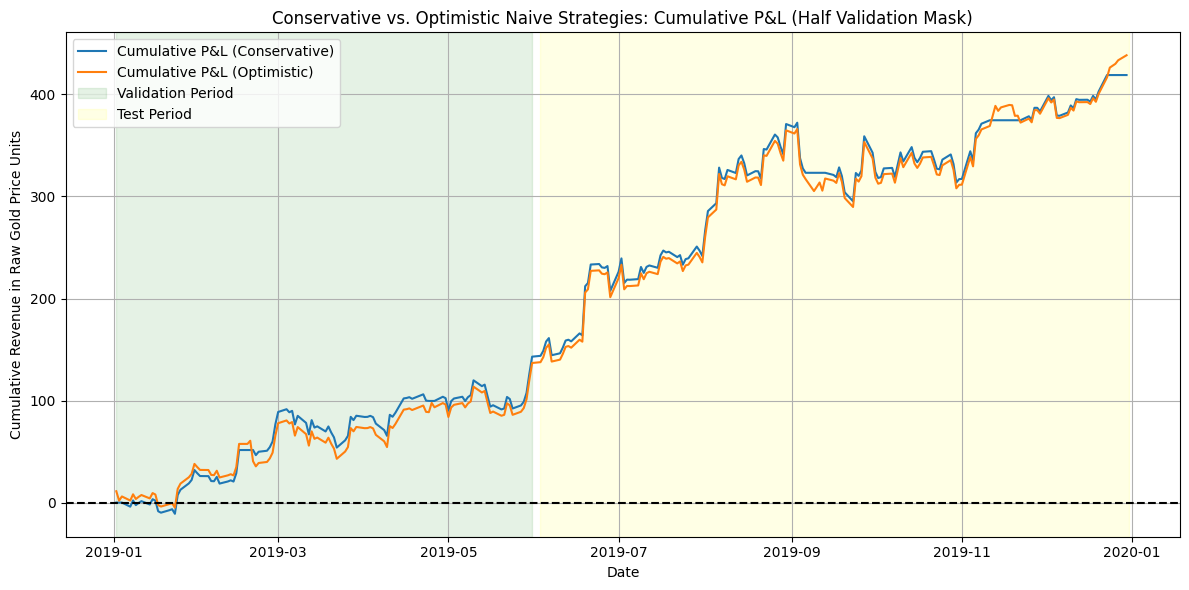

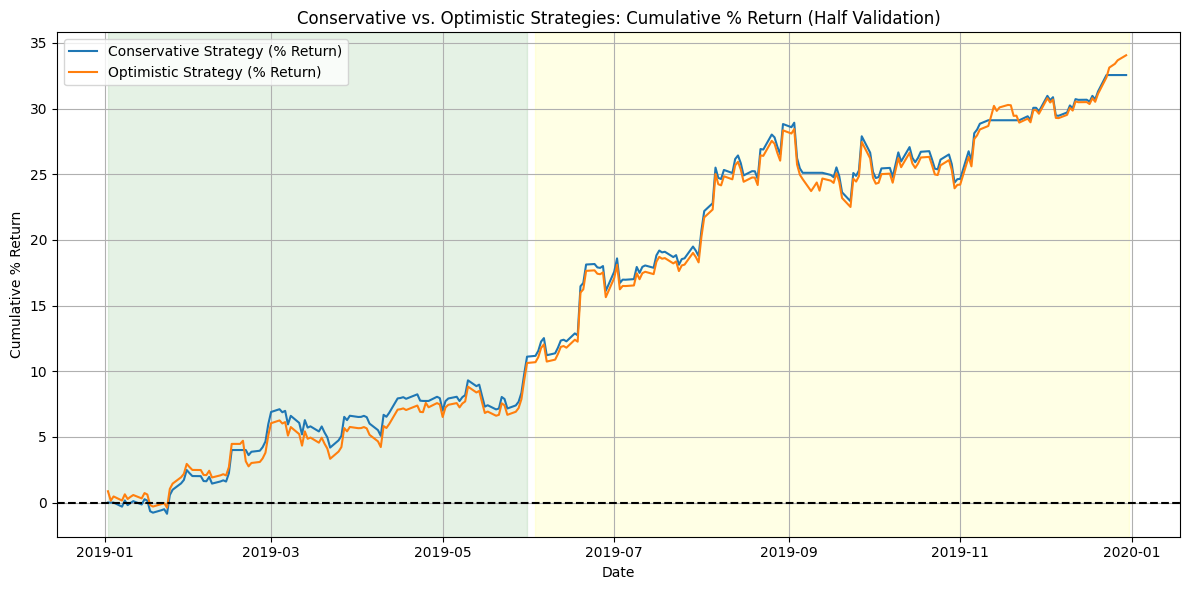

In [4]:
##############################################################################
# MERGED: Conservative & Optimistic Trading Strategies in One Snippet
##############################################################################
import numpy as np

# 1) Choose the same polynomial degree you used for your previous polynomial plots
poly_degree = 29

# 2) Construct the validation+test date arrays
valtest_dates = np.concatenate((val_dates, test_dates))
valtest_date_numeric = mdates.date2num(valtest_dates)

# 3) We'll store derivatives for each day in a dictionary:
#    { modelName: array_of_daily_derivatives, ... }
derivatives_dict = {}

# For the polynomial fitting, you used "training_mask" on the val+test portion.
zoom_dates_train = valtest_dates[training_mask]
zoom_actual_train = np.concatenate((y_val_inv, y_test_inv))[training_mask]
date_numeric_train = mdates.date2num(zoom_dates_train)

# If you want to exclude "Actual" from the trading signals (i.e., only trade on ML models),
# we still compute the "Actual" derivative for reference. You can remove it if unneeded.
coeff_actual_train = np.polyfit(date_numeric_train, zoom_actual_train, poly_degree)
deriv_coeff_actual = np.polyder(coeff_actual_train)
valtest_deriv_actual = np.polyval(deriv_coeff_actual, valtest_date_numeric)
derivatives_dict['Actual'] = valtest_deriv_actual

# 4) Fit polynomials & compute derivatives for each model on val+test
model_list_for_trading = ['LSTM', 'GRU', 'RNN', 'CNN', 'EnhancedLSTM']
for m in model_list_for_trading:
    # Concatenate validation + test predictions for this model
    y_pred_valtest = np.concatenate((
        all_results[m]['y_val_pred_inv'],
        all_results[m]['y_test_pred_inv']
    ))
    # Fit the polynomial on the "training" portion
    y_pred_train = y_pred_valtest[training_mask]
    coeff_model_train = np.polyfit(date_numeric_train, y_pred_train, poly_degree)
    deriv_coeff_model = np.polyder(coeff_model_train)
    valtest_deriv_model = np.polyval(deriv_coeff_model, valtest_date_numeric)
    derivatives_dict[m] = valtest_deriv_model

# 5) Construct Conservative signals: +1 if ALL > 0, -1 if ALL < 0, else 0
num_days = len(valtest_dates)
conservative_signs = np.zeros(num_days, dtype=int)

for i in range(num_days):
    # Evaluate each ML model's derivative at day i
    signs_today = []
    for m in model_list_for_trading:
        if derivatives_dict[m][i] > 0:
            signs_today.append(+1)
        elif derivatives_dict[m][i] < 0:
            signs_today.append(-1)
        else:
            signs_today.append(0)  # treat exact zero as neutral => no full agreement
    
    # If *all* +1 => +1, if *all* -1 => -1, else 0
    if all(s == +1 for s in signs_today):
        conservative_signs[i] = +1
    elif all(s == -1 for s in signs_today):
        conservative_signs[i] = -1
    else:
        conservative_signs[i] = 0

# 6) Construct Optimistic signals: +1 if ANY > 0, -1 if ANY < 0, else 0
optimistic_signs = np.zeros(num_days, dtype=int)

for i in range(num_days):
    signs_today = []
    for m in model_list_for_trading:
        if derivatives_dict[m][i] > 0:
            signs_today.append(+1)
        elif derivatives_dict[m][i] < 0:
            signs_today.append(-1)
        else:
            signs_today.append(0)
    
    # If any +1 => +1, else if any -1 => -1, else 0
    if any(s > 0 for s in signs_today):
        optimistic_signs[i] = +1
    elif any(s < 0 for s in signs_today):
        optimistic_signs[i] = -1
    else:
        optimistic_signs[i] = 0

# 7) Compute daily & cumulative P&L for each strategy
valtest_actual_prices = np.concatenate((y_val_inv, y_test_inv))

# Conservative P&L
conservative_daily_pnl = np.zeros(num_days - 1)
for i in range(num_days - 1):
    position = conservative_signs[i]
    price_diff = valtest_actual_prices[i+1] - valtest_actual_prices[i]
    conservative_daily_pnl[i] = position * price_diff
conservative_cumulative_pnl = np.cumsum(conservative_daily_pnl)

# Optimistic P&L
optimistic_daily_pnl = np.zeros(num_days - 1)
for i in range(num_days - 1):
    position = optimistic_signs[i]
    price_diff = valtest_actual_prices[i+1] - valtest_actual_prices[i]
    optimistic_daily_pnl[i] = position * price_diff
optimistic_cumulative_pnl = np.cumsum(optimistic_daily_pnl)

# 8) Print final results

# ---- Conservative results ----
print("\n====== Conservative Strategy Results ======")
print("Total Trading Days (val+test):", num_days)
print(f"Final Day Cumulative P&L: {conservative_cumulative_pnl[-1]:.2f}")

# Count position days
long_days_conservative = np.sum(conservative_signs == +1)
short_days_conservative = np.sum(conservative_signs == -1)
flat_days_conservative = np.sum(conservative_signs == 0)

print("\n-- Conservative Position Counts --")
print(f" Long days:  {long_days_conservative}")
print(f" Short days: {short_days_conservative}")
print(f" Flat days:  {flat_days_conservative}")

# ---- Optimistic results ----
print("\n====== Most Optimistic Strategy Results ======")
print("Total (val+test) Days:", num_days)
print(f"Final Day Cumulative P&L: {optimistic_cumulative_pnl[-1]:.2f}")

long_days_optimistic = np.sum(optimistic_signs == +1)
short_days_optimistic = np.sum(optimistic_signs == -1)
flat_days_optimistic = np.sum(optimistic_signs == 0)

print("\n-- Optimistic Position Counts --")
print(f" Long days:  {long_days_optimistic}")
print(f" Short days: {short_days_optimistic}")
print(f" Flat days:  {flat_days_optimistic}")

# 9) Plot both cumulative revenue curves on the SAME figure
plt.figure(figsize=(12, 6))
plt.plot(valtest_dates[:-1], conservative_cumulative_pnl, label='Cumulative P&L (Conservative)')
plt.plot(valtest_dates[:-1], optimistic_cumulative_pnl, label='Cumulative P&L (Optimistic)')

plt.axhline(y=0, color='black', linestyle='--')
plt.title("Conservative vs. Optimistic Naive Strategies: Cumulative P&L (Half Validation Mask)")
plt.xlabel("Date")
plt.ylabel("Cumulative Revenue in Raw Gold Price Units")
plt.grid(True)

# Optionally shade validation & test windows
plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1, label='Validation Period')
plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1, label='Test Period')

plt.legend()
plt.tight_layout()
plt.show()



##############################################################################
# Example: Convert daily P&L to % returns relative to initial gold price
##############################################################################
import numpy as np
import matplotlib.pyplot as plt

# Suppose you already have:
#   valtest_dates           : array of datetimes (val+test period)
#   valtest_actual_prices   : actual gold prices over val+test
#   conservative_signs      : array of positions (+1, -1, 0) for each day
#   ... or optimistic_signs

num_days = len(valtest_dates)
initial_price = valtest_actual_prices[0]  # Price on the first day of val+test

# 1) Re-compute daily P&L in absolute terms (if not already done)
conservative_daily_pnl = np.zeros(num_days - 1)
for i in range(num_days - 1):
    position = conservative_signs[i]
    price_diff = valtest_actual_prices[i+1] - valtest_actual_prices[i]
    conservative_daily_pnl[i] = position * price_diff

# 2) Convert daily P&L to daily % of the *initial* gold price
conservative_daily_pnl_pct = (conservative_daily_pnl / initial_price) * 100.0

# 3) Compute the *cumulative* sum of these daily percentage changes
conservative_cumulative_pct = np.cumsum(conservative_daily_pnl_pct)

# Similarly for an 'optimistic_signs' strategy:
optimistic_daily_pnl = np.zeros(num_days - 1)
for i in range(num_days - 1):
    position = optimistic_signs[i]
    price_diff = valtest_actual_prices[i+1] - valtest_actual_prices[i]
    optimistic_daily_pnl[i] = position * price_diff

optimistic_daily_pnl_pct = (optimistic_daily_pnl / initial_price) * 100.0
optimistic_cumulative_pct = np.cumsum(optimistic_daily_pnl_pct)

# 4) Plot both strategies on one figure
plt.figure(figsize=(12, 6))
plt.plot(valtest_dates[:-1], conservative_cumulative_pct, label='Conservative Strategy (% Return)')
plt.plot(valtest_dates[:-1], optimistic_cumulative_pct, label='Optimistic Strategy (% Return)')
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Conservative vs. Optimistic Strategies: Cumulative % Return (Half Validation)")
plt.xlabel("Date")
plt.ylabel("Cumulative % Return")
plt.grid(True)
plt.legend()
plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1, label='Validation Period')
plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1, label='Test Period')
plt.tight_layout()
plt.show()

